# '1997-2005' Model

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
df = pd.read_csv('extracted_big.csv')

## Final Data Prep

### Split and Scale

In [2]:
# set X test and train
mask = df['race_id']<5500
X_train = df[mask].drop(['result','won'],axis=1)
X_test = df[~mask].drop(['result','won'],axis=1).reset_index(drop=True)

# set y test and train
y = 'result' # or 'won'
y_train = df.loc[mask,y]
y_test = df.loc[~mask,y].reset_index(drop=True)

# display split
split = pd.DataFrame()
split['n'] = [X_train.shape[0],X_test.shape[0]]
split['%'] = [X_train.shape[0]/df.shape[0],X_test.shape[0]/df.shape[0]]
split.rename(index={0:'Train',1:'Test'})

,n,%
Train,62850,0.897037
Test,7214,0.102963


In [3]:
# load scale library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scale data
scale = ['horse_age', 'horse_rating', 'declared_weight','actual_weight', 'draw', 'win_odds', 
         'place_odds', 'distance','race_class', 'temprature', 'race_count', 'days_since_race', 'recent_result', 
         'average_result', 'recent_lengths_behind', 'average_lengths_behind', 'recent_normal_speed',
         'average_normal_speed', 'recent_race_class','average_race_class', 'recent_draw', 'average_draw',
         'recent_actual_weight', 'average_actual_weight', 'distance_pref', 'surface_pref', 
         'going_pref', 'venue_pref', 'recent_jockey_prof','average_jockey_prof', 'recent_trainer_perf', 
         'average_trainer_perf', 'recent_jockey_skill', 'average_jockey_skill']

# initiate scalar
#scaler = StandardScaler()
scaler = MinMaxScaler()

# fit and transform sets
scaler.fit(X_train[scale])
X_train[scale] = scaler.transform(X_train[scale])
X_test[scale] = scaler.transform(X_test[scale])

# save and remove 'race_id'
race_id_train = X_train['race_id']
race_id_test = X_test['race_id']
X_train = X_train.drop('race_id',axis=1)
X_test = X_test.drop('race_id',axis=1)

X_train.head()

,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,surface,distance,race_class,...,config_C+3,going_GOOD,going_GOOD TO FIRM,going_GOOD TO YIELDING,going_SLOW,going_SOFT,going_WET FAST,going_WET SLOW,going_YIELDING,going_YIELDING TO SOFT
0,0.142857,0.378151,0.650888,0.700000,0.285714,0.265306,0.083146,0,0.428571,0.307692,...,0,0,1,0,0,0,0,0,0,0
1,0.142857,0.378151,0.535503,0.500000,0.071429,0.091837,0.020225,0,0.428571,0.307692,...,0,0,1,0,0,0,0,0,0,0
2,0.142857,0.378151,0.692308,0.766667,0.857143,0.036735,0.010112,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0
3,0.142857,0.378151,0.582840,0.933333,0.214286,0.084694,0.014607,0,0.571429,0.307692,...,0,0,0,1,0,0,0,0,0,0
4,0.142857,0.378151,0.647929,0.666667,0.285714,0.034694,0.006742,0,0.571429,0.307692,...,0,0,0,1,0,0,0,0,0,0


## Feature Selection

#### Accuracy Function

In [4]:
# define true positive acuracy for 1st place function
def p_accuracy(y_hat,y_true):
    y_hat_1 = y_hat == 1
    y_1 = y_true == 1
    y_0 = y_true == 0
    tp = np.mean(y_hat_1 & y_1)
    fp = np.mean(y_hat_1 & y_0)
    return tp, fp

#### Best Parameters for Model with 'Won' Target
 - logistic: class_weight='balanced', C=1, solver='saga', penalty='l2'
 - decision tree: ctiterion='entropy', class_weight='none'
 
#### Best Parameters for Model with 'Result' Target
 - logistic: class_weight='balanced', C=10, solver='saga', penalty='l2'
 - decision tree: ctiterion='entropy', class_weight='none'

#### Embedded Method: Lasso Regulation

In [5]:
# load libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# define parameters and structures
alphas=10**np.linspace(1,-2,100)*0.5
tps = []
fps = []
lcoef = []
R2 = []

# find best alpha
for alpha in alphas:
    
    # run lasso for each alpha
    lasso = Lasso(alpha=alpha, copy_X=True, random_state=42, max_iter=100000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    tp, fp = p_accuracy(y_pred, y_test)
    tps += [tp]
    fps += [fp]
    lcoef += [lasso.coef_.tolist()]
    R2 += [r2_score(y_test, y_pred)]

Best Lasso
Alpha: 0.005
R2   : 0.264
TP   : 0.0
FP   : 0.0


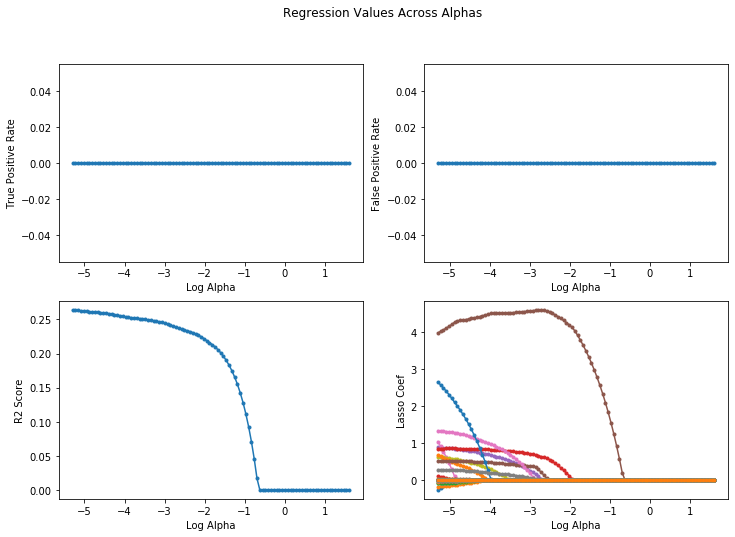

In [6]:
# output best alpha and R2
TP = pd.Series(tps)
R2 = pd.Series(R2)
FP = pd.Series(fps)
idxmax = R2.idxmax()
print('Best Lasso\nAlpha:', alphas[idxmax])
print('R2   :',round(R2[idxmax],3))
print('TP   :',round(TP[idxmax],3))
print('FP   :',round(FP[idxmax],3))

# plot R2 and Coef
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2,figsize=(12,8))
fig.suptitle('Regression Values Across Alphas')

ax1.plot(np.log(alphas), TP, '.-')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('Log Alpha')

ax2.plot(np.log(alphas), FP, '.-')
ax2.set_ylabel('False Positive Rate')
ax2.set_xlabel('Log Alpha')

ax3.plot(np.log(alphas), R2, '.-')
ax3.set_ylabel('R2 Score')
ax3.set_xlabel('Log Alpha')

ax4.plot(np.log(alphas), lcoef, '.-')
ax4.set_ylabel('Lasso Coef')
ax4.set_xlabel('Log Alpha')

plt.show()

In [7]:
# store best
lasso = Lasso(alpha=alphas[idxmax], copy_X=True, random_state=42, max_iter=100000)
lasso.fit(X_train, y_train)

# set lasso X test and train
coef = lasso.coef_ > 0
X_train_lasso = X_train.iloc[:,coef]
X_test_lasso = X_test.iloc[:,coef].reset_index(drop=True)

# show non-zero coeff
print('# non-zero coef:', len(coef[coef == True]))
X_train_lasso.head()

# non-zero coef: 14


,actual_weight,draw,win_odds,place_odds,surface,distance,race_count,recent_result,distance_pref,surface_pref,average_jockey_prof,recent_trainer_perf,horse_country_AUS,venue_ST
0,0.700000,0.285714,0.265306,0.083146,0,0.428571,0.0,0.769231,0.769231,0.769231,0.526627,0.230769,0,1
1,0.500000,0.071429,0.091837,0.020225,0,0.428571,0.0,0.461538,0.461538,0.461538,0.576923,0.615385,1,1
2,0.766667,0.857143,0.036735,0.010112,0,0.285714,0.0,0.153846,0.153846,0.153846,0.393162,0.538462,1,1
3,0.933333,0.214286,0.084694,0.014607,0,0.571429,0.0,0.384615,0.384615,0.384615,0.454849,0.538462,0,0
4,0.666667,0.285714,0.034694,0.006742,0,0.571429,0.0,0.769231,0.769231,0.769231,0.520147,0.692308,0,0


#### Wrapper Methods: Stepwise Forward and Backwards Exlusion (RFE) 

C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


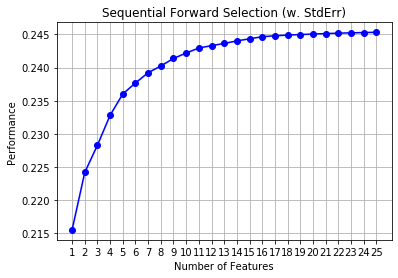

In [8]:
# import feature selection libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Sequential Forward Selection (sfs) with R2 as evaluator
# using LinearRegression for speed
sfs = SFS(LinearRegression(), k_features=25, forward=True, floating=False, scoring = 'r2', cv = 0)
sfs.fit(X_train, y_train)

# plot to find best # of feature to select
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [9]:
# save selected features to X test & train
coef = sfs.k_feature_names_[0:17]
X_train_forward = X_train.loc[:,coef]
X_test_forward = X_test.loc[:,coef].reset_index(drop=True)

# show selected features
print('# selected features:', len(coef))
X_train_forward.head()

# selected features: 17


,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,distance,race_count,days_since_race,recent_result,average_normal_speed,recent_race_class,recent_draw,distance_pref,surface_pref,going_pref
0,0.142857,0.378151,0.650888,0.700000,0.285714,0.265306,0.083146,0.428571,0.0,0.002737,0.769231,0.292431,0.307692,0.857143,0.769231,0.769231,0.769231
1,0.142857,0.378151,0.535503,0.500000,0.071429,0.091837,0.020225,0.428571,0.0,0.000912,0.461538,0.350537,0.307692,0.071429,0.461538,0.461538,0.461538
2,0.142857,0.378151,0.692308,0.766667,0.857143,0.036735,0.010112,0.285714,0.0,0.002737,0.153846,0.195348,0.384615,0.714286,0.153846,0.153846,0.153846
3,0.142857,0.378151,0.582840,0.933333,0.214286,0.084694,0.014607,0.571429,0.0,0.003650,0.384615,0.350178,0.307692,0.785714,0.384615,0.384615,0.384615
4,0.142857,0.378151,0.647929,0.666667,0.285714,0.034694,0.006742,0.571429,0.0,0.005474,0.769231,0.273634,0.307692,0.785714,0.769231,0.769231,0.769231


C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


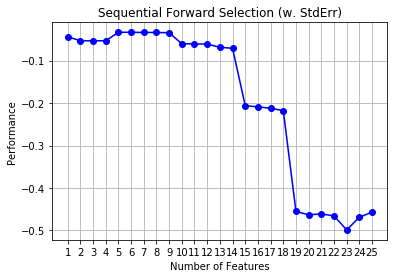

In [77]:
# import feature selection libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Sequential Forward Selection (sfs) with R2 as evaluator
logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
sfs1 = SFS(logit, k_features=25, forward=True, floating=False, scoring = 'r2', cv = 0)
sfs1.fit(X_train, y_train)

# plot to find best # of feature to select
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [87]:
# save selected features to X test & train
end = 10
coef = pd.Series(sfs1.k_feature_names_[0:end])
sfs_train = X_train[coef]
sfs_test = X_test[coef].reset_index(drop=True)

# show selected features
print('# selected features:', len(coef))
sfs_test.head()

# selected features: 10


,place_odds,race_count,average_jockey_prof,horse_country_BRZ,horse_country_CAN,horse_country_GER,horse_country_GR,horse_country_ITY,horse_country_JPN,horse_country_SAF
0,0.011236,0.345238,0.515907,0,0,0,0,0,0,0
1,0.086517,0.202381,0.372475,0,0,0,0,0,0,0
2,0.017978,0.071429,0.362332,0,0,0,0,0,0,0
3,0.017978,0.071429,0.433832,0,0,0,0,0,0,0
4,0.014607,0.178571,0.263454,0,0,0,0,0,0,0


#### RFE

In [ ]:
# import feature selection libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# run recursive feature elimination
n = 18
estimator = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
rfe = RFE(estimator, n_features_to_select=n, step=1) #18 is best for rfe
rfe = rfe.fit(X_train, y_train)

In [13]:
# get test and train
#cols = rfe.support_
cols = ['place_odds','surface','average_trainer_perf','horse_country_AUS',
       'horse_country_CAN','horse_country_FR','horse_country_GB',
       'horse_country_GER','horse_country_IRE','horse_country_ITY',
       'horse_country_NZ','horse_country_SAF','horse_country_USA',
       'horse_type_Colt','horse_type_Horse','horse_type_Mare',
       'horse_type_Rig','venue_ST']
rfe_train = X_train.loc[:,cols]
rfe_test = X_test.loc[:,cols]

# output RFE results
'''test_pred = rfe.estimator_.predict(rfe_test)
train_acc = round(rfe.estimator_.score(rfe_train, y_train),4)
test_acc = round(rfe.estimator_.score(rfe_test, y_test),4)
r2 = round(r2_score(y_test, test_pred),4)
print('RFE Results')
print('Number Features:',n)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',test_acc)
print('R2 Score:',r2)'''

rfe_train.head()

,place_odds,surface,average_trainer_perf,horse_country_AUS,horse_country_CAN,horse_country_FR,horse_country_GB,horse_country_GER,horse_country_IRE,horse_country_ITY,horse_country_NZ,horse_country_SAF,horse_country_USA,horse_type_Colt,horse_type_Horse,horse_type_Mare,horse_type_Rig,venue_ST
0,0.083146,0,0.561111,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0.020225,0,0.563725,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.010112,0,0.437500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.014607,0,0.469697,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.006742,0,0.503788,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### PCA Method

Min PC to Explain 80% Variance: 16
% Explained: 80.08


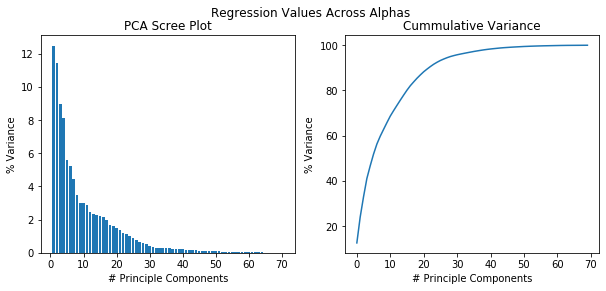

In [32]:
# load PCA libraries
from sklearn.decomposition import PCA

# run PCA
pca_70 = PCA(n_components=70)
pc70_train = pd.DataFrame(pca_70.fit_transform(X_train))
pc70_test = pd.DataFrame(pca_70.transform(X_test))

# find desired size (80% of variance)
percent_variance = np.round(pca_70.explained_variance_ratio_*100, decimals=2)
cum_variance = []
cum = 0
for i in percent_variance:
    cum += i
    cum_variance += [cum]
    
# get # of PC to explain 80% of variance
cum_variance = pd.Series(cum_variance)
idxmin = cum_variance[cum_variance >= 80].idxmin()
print('Min PC to Explain 80% Variance:',idxmin+1)
print('% Explained:', cum_variance[idxmin])

# split into PC_small = pc15 test and train data
pc15_train = pc70_train.iloc[:,0:idxmin]
pc15_test = pc70_test.iloc[:,0:idxmin]

# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Regression Values Across Alphas')

ax1.bar(x= range(1,71), height=percent_variance)
ax1.set_title('PCA Scree Plot')
ax1.set_ylabel('% Variance')
ax1.set_xlabel('# Principle Components')

ax2.plot(cum_variance)
ax2.set_title('Cummulative Variance')
ax2.set_ylabel('% Variance')
ax2.set_xlabel('# Principle Components')

plt.show()

In [97]:
# output features for quick hard coding
print('Forward (linear):\n',X_train_forward.columns.values)
print('Forward (logit):\n',sfs_train.columns.values)
print('RFE:\n',rfe_train.columns.values)

Forward (linear):
 ['horse_age' 'horse_rating' 'declared_weight' 'actual_weight' 'draw'
 'win_odds' 'place_odds' 'distance' 'race_count' 'days_since_race'
 'recent_result' 'average_normal_speed' 'recent_race_class' 'recent_draw'
 'distance_pref' 'surface_pref' 'going_pref']
Forward (logit):
 ['place_odds' 'race_count' 'average_jockey_prof' 'horse_country_BRZ'
 'horse_country_CAN' 'horse_country_GER' 'horse_country_GR'
 'horse_country_ITY' 'horse_country_JPN' 'horse_country_SAF']
RFE:
 ['place_odds' 'surface' 'average_trainer_perf' 'horse_country_AUS'
 'horse_country_CAN' 'horse_country_FR' 'horse_country_GB'
 'horse_country_GER' 'horse_country_IRE' 'horse_country_ITY'
 'horse_country_NZ' 'horse_country_SAF' 'horse_country_USA'
 'horse_type_Colt' 'horse_type_Horse' 'horse_type_Mare' 'horse_type_Rig'
 'venue_ST']


In [ ]:
# Forward (linear)
cols = ['horse_age' 'horse_rating' 'declared_weight' 'actual_weight' 'draw'
 'win_odds' 'place_odds' 'distance' 'race_count' 'days_since_race'
 'recent_result' 'average_normal_speed' 'recent_race_class' 'recent_draw'
 'distance_pref' 'surface_pref' 'going_pref']
X_train_forward = X_train[cols]
X_test_forward = X_test[cols]

# Forward (logit)
cols =  ['place_odds' 'race_count' 'average_jockey_prof' 'horse_country_BRZ'
 'horse_country_CAN' 'horse_country_GER' 'horse_country_GR'
 'horse_country_ITY' 'horse_country_JPN' 'horse_country_SAF']
sfs_train = X_train[cols]
sfs_test = X_test[cols]

# RFE
cols = ['place_odds' 'surface' 'average_trainer_perf' 'horse_country_AUS'
 'horse_country_CAN' 'horse_country_FR' 'horse_country_GB'
 'horse_country_GER' 'horse_country_IRE' 'horse_country_ITY'
 'horse_country_NZ' 'horse_country_SAF' 'horse_country_USA'
 'horse_type_Colt' 'horse_type_Horse' 'horse_type_Mare' 'horse_type_Rig'
 'venue_ST']
rfe_train = X_train[cols]
rfe_test = X_test[cols]

## Model Exploration: Simple Models 

Selected features: complete, lasso, forward, RFE, PCA 70, PCA 15

In [182]:
# select what models to run
knn_key = True
lin_key = True
logit_key = True
dt_key = True
bagging_key = True

# select what selections to run
lasso_key = True
f_key = True
f2_key = True
rfe_key = True
pc_key = True

### kNN

In [183]:
# load knn library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

def get_best_knn(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if knn_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run knn model
    test_error = []
    train_error = []
    r2 = []
    for n in range(2,20):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        pred_test = knn.predict(X_test)
        pred_train = knn.predict(X_train)
        train_error.append(np.mean(pred_train != y_train))
        test_error.append(np.mean(pred_test != y_test))
        r2.append(r2_score(y_test, pred_test))

    # plot knn error
    error = pd.DataFrame([test_error, train_error], index=['Test','Train']).T
    error.plot(figsize=(12,4))
    plt.title('Error Rate Over K Value')
    plt.xlabel('K Value')
    plt.ylabel('Error')
    plt.show()
    
    # out best errors
    train_error = pd.Series(train_error)
    r2 = pd.Series(r2)
    min_test = min(test_error)
    train_acc = 1 - round(train_error[test_error == min_test].values[0],4)
    k = train_error[test_error == min_test].index[0]
    r2 = round(r2[test_error == min_test].values[0],4)
    test_acc = 1- round(min_test,4)
    
    return [train_acc, test_acc, r2]

In [ ]:
# get best kNN on complete set
kout_c = get_best_knn(X_train,X_test,y_train,y_test)

# output kNN results
out = pd.DataFrame()
out['Complete'] = [k, test_acc, train_acc, r2]
out.rename(index={0:'k value',1:'Train Accuracy',2:'Test Accuracy',3:'R2 Score'})

In [185]:
# best model knn function
def get_knn(k, X_train,X_test,key=True):
    
    # run best model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # calc results
    pred_train = round(pd.Series(knn.predict(X_train)))
    pred_test = round(pd.Series(knn.predict(X_test)))
    train_acc = round(np.mean(pred_train == y_train),4)
    test_acc = round(np.mean(pred_test == y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)

    return knn, [train_acc, test_acc, r2, tp, fp]

In [186]:
# get best knn
k = 4
knn_c, kout_c = get_knn(k, X_train,X_test)
knn_l, kout_l = get_knn(k, X_train_lasso,X_test_lasso)
knn_f, kout_f = get_knn(k, X_train_forward,X_test_forward)

In [187]:
# output logit results
out = pd.DataFrame()
out['Complete'] = kout_c
out['Lasso'] = kout_l
out['Forward'] = kout_f
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward
Train Accuracy,0.363000,0.373900,0.37860
Test Accuracy,0.096100,0.101500,0.10380
R2 Score,-0.722900,-0.611500,-0.66070
TP Rate,0.024258,0.026338,0.02814
FP Rate,0.000000,0.000000,0.00000


### Linear Regression

In [82]:
# load regression library
from sklearn.linear_model import LinearRegression

# define regression function
def get_linearReg(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if lin_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run model
    lin = LinearRegression()
    lin.fit(X_train,y_train)
    
    # calc results
    pred_train = round(pd.Series(lin.predict(X_train)))
    pred_test = round(pd.Series(lin.predict(X_test)))
    train_acc = round(np.mean(pred_train == y_train),4)
    test_acc = round(np.mean(pred_test == y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)
    
    return lin, [train_acc, test_acc, r2, tp, fp]

In [88]:
# output regression results
out = pd.DataFrame()

# get best regression on complete, lasso, forward, rfe, pc_70, and pc_16 sets
lin_c, out['Complete']  = get_linearReg(X_train,X_test,y_train,y_test)
lin_l, out['Lasso'] = get_linearReg(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
lin_f, out['Forward'] = get_linearReg(X_train_forward,X_test_forward,y_train,y_test)
lin_f2, out['Forward 2'] = get_linearReg(sfs_train,sfs_test,y_train,y_test, f2_key)
lin_rfe, out['RFE'] = get_linearReg(rfe_train, rfe_test, y_train, y_test,rfe_key)
lin_70, out['PC_70']  = get_linearReg(pc70_train,pc70_test,y_train,y_test)
lin_15, out['PC_15'] = get_linearReg(pc15_train,pc15_test,y_train,y_test)
out = out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

out

,Complete,Lasso,Forward,Forward 2,RFE,PC_70,PC_15
Train Accuracy,0.1023,0.1015,0.1021,0.0950,0.0948,0.1023,0.0970
Test Accuracy,0.1108,0.1078,0.1048,0.1011,0.1009,0.1106,0.0987
R2 Score,0.2559,0.2601,0.2502,0.2057,0.1906,0.2560,0.2244
TP Rate,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
FP Rate,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Logistic Regression

In [149]:
# load logit library
from sklearn.linear_model import LogisticRegression

# define regression function
def get_logit(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if logit_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run model
    logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
    logit.fit(X_train,y_train)
    
    # calc results
    pred_test = round(pd.Series(logit.predict(X_test)))
    train_acc = round(logit.score(X_train,y_train),4)
    test_acc = round(logit.score(X_test,y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)
    
    return logit, [train_acc, test_acc, r2, tp, fp]

In [150]:
# get best logit on complete, lasso, forward, rfe, pc_70, and pc_16 sets
logit_c, out_c   = get_logit(X_train,X_test,y_train,y_test)
logit_l, out_l = get_logit(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
logit_f, out_f = get_logit(X_train_forward,X_test_forward,y_train,y_test)
logit_f2, out_f2 = get_logit(sfs_train,sfs_test,y_train,y_test, f2_key)
logit_rfe, out_rfe = get_logit(rfe_train, rfe_test, y_train, y_test, rfe_key)
logit_70, out_70 = get_logit(pc70_train,pc70_test,y_train,y_test)
logit_15, out_15 = get_logit(pc15_train,pc15_test,y_train,y_test)

In [151]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward,Forward 2,RFE,PC_70,PC_15
Train Accuracy,0.138300,0.131800,0.132100,0.12690,0.130500,0.138400,0.11820
Test Accuracy,0.136100,0.134900,0.126100,0.12890,0.129600,0.135800,0.10900
R2 Score,-0.624500,-0.664300,-0.524500,-0.41480,-0.652400,-0.625800,-0.77390
TP Rate,0.057111,0.056002,0.061131,0.05725,0.058775,0.057111,0.04214
FP Rate,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000


### Decision Tree Classifier

In [152]:
# load decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def get_decision_tree(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if dt_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run decision tree model
    dtc = DecisionTreeClassifier(random_state=10, criterion='entropy')
    dtc.fit(X_train,y_train)
    
    # get predictions
    test_pred = dtc.predict(X_test)
    train_pred = dtc.predict(X_train)
    
    # calc results
    train_acc = round(accuracy_score(train_pred, y_train),4)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return dtc, [train_acc, test_acc, r2, tp, fp]

In [153]:
# get best decision tree on complete, lasso, forward, rfe, pc_70, and pc_16 sets
dtc_c, out_c = get_decision_tree(X_train,X_test,y_train,y_test)
dtc_l, out_l = get_decision_tree(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
dtc_f, out_f = get_decision_tree(X_train_forward,X_test_forward,y_train,y_test)
dtc_f2, out_f2 = get_decision_tree(sfs_train, sfs_test, y_train, y_test, f2_key)
dtc_rfe, out_rfe = get_decision_tree(rfe_train, rfe_test, y_train, y_test, rfe_key)
dtc_70, out_70 = get_decision_tree(pc70_train, pc70_test, y_train, y_test)
dtc_15, out_15 = get_decision_tree(pc15_train, pc15_test, y_train, y_test)

In [154]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward,Forward 2,RFE,PC_70,PC_15
Train Accuracy,1.000000,1.000000,1.000000,0.999800,0.999600,1.000000,1.000000
Test Accuracy,0.099100,0.100600,0.102000,0.100600,0.105600,0.105200,0.098600
R2 Score,-0.431500,-0.389000,-0.434300,-0.424800,-0.432600,-0.549300,-0.522500
TP Rate,0.014416,0.016496,0.014416,0.012337,0.014001,0.010812,0.011505
FP Rate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Bagging

### Logistic Regression

In [155]:
# load logit library
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# define regression function
def get_bagged_logit(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if logit_key == False or bagging_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run logistic regression ensemble
    logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
    logit_bag = BaggingClassifier(base_estimator=logit, n_estimators=10, random_state=10)
    logit_bag.fit(X_train, y_train)
    
    # get results
    pred_test = round(pd.Series(logit_bag.predict(X_test)))
    train_acc = round(logit_bag.score(X_train,y_train),4)
    test_acc = round(logit_bag.score(X_test,y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)
    
    return logit_bag, [train_acc, test_acc, r2, tp, fp]

In [156]:
# get best logit on complete set
logit_bag_c, lout_c = get_bagged_logit(X_train, X_test, y_train, y_test)

In [157]:
# get best logit on lasso set
logit_bag_l, lout_l = get_bagged_logit(X_train_lasso, X_test_lasso, y_train, y_test, lasso_key)

In [158]:
# get best logit on forward set
logit_bag_f, lout_f = get_bagged_logit(X_train_forward, X_test_forward, y_train, y_test)

In [159]:
# get best logit on forward 2 set
logit_bag_f2, lout_f2 = get_bagged_logit(sfs_train, sfs_test, y_train, y_test, f2_key)

The max_iter was reached which means the coef_ did not converge


In [160]:
# get best logit on RFE set
logit_bag_rfe, lout_rfe = get_bagged_logit(rfe_train, rfe_test, y_train, y_test, rfe_key)

In [161]:
# get best logit on PC_70 set
logit_bag_70, lout_70 = get_bagged_logit(pc70_train,pc70_test,y_train,y_test)

In [162]:
# get best logit on PC_15 set
logit_bag_15, lout_15 = get_bagged_logit(pc15_train,pc15_test,y_train,y_test)

In [163]:
# output logit results
out = pd.DataFrame()
out['Complete'] = lout_c
out['Lasso'] = lout_l
out['Forward'] = lout_f
out['Forward 2'] = lout_f2
out['RFE'] = lout_rfe
out['PC_70'] = lout_70
out['PC_15'] = lout_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward,Forward 2,RFE,PC_70,PC_15
Train Accuracy,0.137100,0.132900,0.131300,0.128000,0.130000,0.137100,0.11850
Test Accuracy,0.135400,0.135300,0.124300,0.127500,0.128900,0.135300,0.11140
R2 Score,-0.628500,-0.647000,-0.520400,-0.410500,-0.647600,-0.629400,-0.76730
TP Rate,0.057111,0.056141,0.060715,0.057111,0.057943,0.056973,0.04214
FP Rate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### Decision Tree Classifier

In [164]:
# load decision tree libraries
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def get_bagged_decision_tree(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if dt_key == False or bagging_key == False or key == False:
        return np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
    
    # run logistic regression ensemble
    dtc = DecisionTreeClassifier(random_state=10, criterion='entropy')
    dtc_bag = BaggingClassifier(base_estimator=dtc, n_estimators=50, random_state=10)
    dtc_bag.fit(X_train, y_train)
    
    # get results
    test_pred = dtc_bag.predict(X_test)
    train_pred = dtc_bag.predict(X_train)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return dtc_bag, [train_acc, test_acc, r2, tp, fp]

In [165]:
# get best decision tree on complete set
dtc_bag_c, dtout_c = get_bagged_decision_tree(X_train,X_test,y_train,y_test)

In [166]:
# get best decision tree on lasso set
dtc_bag_l, dtout_l = get_bagged_decision_tree(X_train_lasso,X_test_lasso,y_train,y_test, lasso_key)

In [167]:
# get best decision tree on forward set
dtc_bag_f, dtout_f = get_bagged_decision_tree(X_train_forward,X_test_forward,y_train,y_test)

In [168]:
# get best decision tree on forward 2 set
dtc_bag_f2, dtout_f2 = get_bagged_decision_tree(sfs_train,sfs_test,y_train,y_test, f2_key)

In [169]:
# get best decision tree on RFE set
dtc_bag_rfe, dtout_rfe = get_bagged_decision_tree(rfe_train, rfe_test, y_train, y_test, rfe_key)

In [170]:
# get best logit on PC_70 set
dtc_bag_70, dtout_70 = get_bagged_decision_tree(pc70_train,pc70_test,y_train,y_test)

In [171]:
# get best logit on PC_15 set
dtc_bag_15, dtout_15 = get_bagged_decision_tree(pc15_train,pc15_test,y_train,y_test)

In [172]:
# output logit results
out = pd.DataFrame()
out['Complete'] = dtout_c
out['Lasso'] = dtout_l
out['Forward'] = dtout_f
out['Forward 2'] = dtout_f2
out['RFE'] = dtout_rfe
out['PC_70'] = dtout_70
out['PC_15'] = dtout_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward,Forward 2,RFE,PC_70,PC_15
Train Accuracy,1.000000,1.000000,1.000000,0.99980,0.999600,1.000000,1.000000
Test Accuracy,0.128500,0.130900,0.124100,0.10550,0.112100,0.127400,0.107300
R2 Score,-0.149500,-0.186800,-0.175000,-0.33960,-0.375900,-0.288000,-0.363700
TP Rate,0.030635,0.031605,0.031744,0.01511,0.015248,0.029249,0.018021
FP Rate,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


### XGBoost

In [ ]:
o = pd.DataFrame()
xgout = pd.DataFrame()
xgout = xgout.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

In [177]:
# load XGBoost libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBClassifier
import xgboost as xgb
import shap

# define parameters (need to fine tune)
'''
gamma=11
min_child_weight=5
'''

# define XGBoost function
def get_XGBoost(X_train, X_test):
            
    # setup parameters
    bst = XGBClassifier(random_state=10, learning_rate=0.1, n_estimators = 100,
                        max_depth=5, objective='multi:softmax')
    bst.fit(X_train, y_train)
    
    '''
    parameters = {'n_estimators':[100,500,1000]}
    
    # run XGBoost search
    srch = GridSearchCV(bst, parameters, refit=True)
    srch.fit(X_train, y_train)

    # make test prediction
    test_pred = srch.predict(X_test)
    train_pred = srch.predict(X_train)
    '''
    
    # make best prediction
    test_pred = bst.predict(X_test)
    train_pred = bst.predict(X_train)
    
    # calc output
    test_acc = round(accuracy_score(test_pred, y_test),4)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    best_params = '' # srch.best_params_
    
    return bst, best_params, [train_acc, test_acc, r2, tp, fp]

In [148]:
col = str(best_params_l)
o[col] = expected_earnings(X_train_lasso, X_test_lasso, bst_l)
o


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,"{'learning_rate': 0.1, 'max_depth': 5}","{'gamma': 10, 'min_child_weight': 5}",{'gamma': 11},{'n_estimators': 100}
Bets Made,127.00,479.00,518.00,127.00
Winnings ($),257.11,453.86,453.86,257.11
Profit ($),130.11,-25.14,-64.14,130.11
Profit per Bet ($/bet),1.02,-0.05,-0.12,1.02
Return on Bets (%),102.40,-5.20,-12.40,102.40


In [179]:
# get best decision tree on complete, lasso, and forward sets
bst_c, bp, out_c = get_XGBoost(X_train,X_test)
bst_l, bp, out_l = get_XGBoost(X_train_lasso,X_test_lasso)
bst_f, bp, out_f = get_XGBoost(X_train_forward,X_test_forward)

In [180]:
# output random forest results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete,Lasso,Forward
Train Accuracy,0.286200,0.2266,0.245100
Test Accuracy,0.144700,0.1447,0.138500
R2 Score,-0.182500,-0.1201,-0.187500
TP Rate,0.041031,0.0402,0.043526
FP Rate,0.000000,0.0000,0.000000


In [189]:
# XGBoost earnings
earnings2 = pd.DataFrame()

# get XGBoost estimates
earnings2['XGBoost - Complete'] = expected_earnings(X_train, X_test, bst_c)
earnings2['XGBoost - Lasso'] = expected_earnings(X_train_lasso,X_test_lasso, bst_l)
earnings2['XGBoost - Forward'] = expected_earnings(X_train_forward,X_test_forward, bst_f)
earnings2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,XGBoost - Complete,XGBoost - Lasso,XGBoost - Forward
Bets Made,108.00,127.00,147.00
Wins,3.00,2.00,6.00
Winnings ($),34.84,257.11,207.02
Profit ($),-73.16,130.11,60.02
Profit per Bet ($/bet),-0.68,1.02,0.41
Return on Bets (%),-67.70,102.40,40.80


## Baseline

In [195]:
out = pd.DataFrame()
logit_b, out['Baseline'] = get_logit(X_train[['win_odds']],X_test[['win_odds']],y_train,y_test)
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Baseline
Train Accuracy,0.119500
Test Accuracy,0.122400
R2 Score,-0.655200
TP Rate,0.061824
FP Rate,0.000000


## Ensemble

In [260]:
# combine best models of each type
def ens(test=True, forward=True, lasso=True, evaluate=False):
    
    # define data structure
    ensemble = pd.DataFrame()
    
    # check if evaluation or prediction
    if evaluate == True:
        
        # check if test or train
        if test == True:
            # check if lasso is on
            if lasso == True:
                ensemble['Decision Tree - Lasso'] = pd.DataFrame(dtc_l.predict(X_test_lasso))[0]
                ensemble['Bagged Logit - Lasso'] = pd.DataFrame(logit_bag_l.predict(X_test_lasso))[0]
                ensemble['XGBoost - Lasso'] = pd.DataFrame(bst_l.predict(X_test_lasso))[0]

            # check if forward is on
            if forward == True:
                ensemble['Decision Tree - Forward'] = pd.DataFrame(dtc_f.predict(X_test_forward))[0]
                ensemble['Bagged Logit - Forward'] = pd.DataFrame(logit_bag_f.predict(X_test_forward))[0]
                ensemble['XGBoost - Forward'] = pd.DataFrame(bst_f.predict(X_test_forward))[0]

        else:
            # check if lasso is on
            if lasso == True:
                ensemble['Decision Tree - Lasso'] = pd.DataFrame(dtc_l.predict(X_train_lasso))[0]
                ensemble['Bagged Logit - Lasso'] = pd.DataFrame(logit_bag_l.predict(X_train_lasso))[0]
                ensemble['XGBoost - Lasso'] = pd.DataFrame(bst_l.predict(X_train_lasso))[0]
                
            # check if forward is on
            if forward == True:
                ensemble['Decision Tree - Forward'] = pd.DataFrame(dtc_f.predict(X_train_forward))[0]
                ensemble['Bagged Logit - Forward'] = pd.DataFrame(logit_bag_f.predict(X_train_forward))[0]
                ensemble['XGBoost - Forward'] = pd.DataFrame(bst_f.predict(X_train_forward))[0]
    
    # run if prediction
    else:
        # check if test or train
        if test == True:
            # check if lasso is on
            if lasso == True:
                ensemble['Decision Tree - Lasso'] = pd.DataFrame(dtc_l.predict_proba(X_test_lasso))[0]
                ensemble['Bagged Logit - Lasso'] = pd.DataFrame(logit_bag_l.predict_proba(X_test_lasso))[0]
                ensemble['XGBoost - Lasso'] = pd.DataFrame(bst_l.predict_proba(X_test_lasso))[0]

            # check if forward is on
            if forward == True:
                ensemble['Decision Tree - Forward'] = pd.DataFrame(dtc_f.predict_proba(X_test_forward))[0]
                ensemble['Bagged Logit - Forward'] = pd.DataFrame(logit_bag_f.predict_proba(X_test_forward))[0]
                ensemble['XGBoost - Forward'] = pd.DataFrame(bst_f.predict_proba(X_test_forward))[0]

        else:
            # check if lasso is on
            if lasso == True:
                ensemble['Decision Tree - Lasso'] = pd.DataFrame(dtc_l.predict_proba(X_train_lasso))[0]
                ensemble['Bagged Logit - Lasso'] = pd.DataFrame(logit_bag_l.predict_proba(X_train_lasso))[0]
                ensemble['XGBoost - Lasso'] = pd.DataFrame(bst_l.predict_proba(X_train_lasso))[0]

            # check if forward is on
            if forward == True:
                ensemble['Decision Tree - Forward'] = pd.DataFrame(dtc_f.predict_proba(X_train_forward))[0]
                ensemble['Bagged Logit - Forward'] = pd.DataFrame(logit_bag_f.predict_proba(X_train_forward))[0]
                ensemble['XGBoost - Forward'] = pd.DataFrame(bst_f.predict_proba(X_train_forward))[0]
        
    return ensemble.T.apply(np.mean)

def get_ensemble(forward=True, lasso=True):
    
    # make best prediction
    test_pred = round(ens(test=True, forward=forward, lasso=lasso, evaluate=True))
    train_pred = round(ens(test=False, forward=forward, lasso=lasso, evaluate=True))
    
    # calc output
    test_acc = round(accuracy_score(test_pred, y_test),4)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return [train_acc, test_acc, r2, tp, fp]

In [262]:
eout_b = get_ensemble(forward=True, lasso=True)
eout_l = get_ensemble(forward=False, lasso=True)
eout_f = get_ensemble(forward=True, lasso=False)

In [263]:
out = pd.DataFrame()
out['Both'] = eout_b
out['Lasso'] = eout_l
out['Forward'] = eout_f
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Both,Lasso,Forward
Train Accuracy,0.210300,0.201400,0.203500
Test Accuracy,0.134600,0.138300,0.127700
R2 Score,0.042600,-0.019900,-0.029000
TP Rate,0.012476,0.020377,0.018714
FP Rate,0.000000,0.000000,0.000000


## Expected Earnings

In [226]:
# load estimaton library
from sklearn.linear_model import LogisticRegression

# define expected earnings function
def expected_earnings(train_df, test_df, model, PC=False, ENS=False, forward=True, lasso=True):
    
    # build df
    if PC == True:
        # initalize test data
        df = X_test.copy()
        df['target_prob'] = pd.DataFrame(model.predict_proba(test_df))[0] # only get prob for 1st place
        
        # initalize train data
        df2 = X_test.copy()
        df2['target_prob'] = pd.DataFrame(model.predict_proba(test_df))[0] # only get prob for 1st place
        
    elif ENS != False:
        # initalize test data
        df = X_test.copy()
        df['target_prob'] = pd.DataFrame(ens(forward=forward,lasso=lasso,test=True))[0] # only get prob for 1st place
        
        # initalize train data
        df2 = X_test.copy()
        df2['target_prob'] = pd.DataFrame(ens(forward=forward,lasso=lasso,test=False))[0] # only get prob for 1st place
        
    else:  
        # initalize test data
        df = test_df.copy()
        df['target_prob'] = pd.DataFrame(model.predict_proba(df))[0] # only get prob for 1st place
        
        # initalize train data
        df2 = train_df.copy()
        df2['target_prob'] = pd.DataFrame(model.predict_proba(df2))[0] # only get prob for 1st place
    
    # finish initalization
    df['results'] = y_test
    df2['results'] = y_test
    df = df.merge(race_id_test,left_index=True,right_index=True)    
    df2 = df2.merge(race_id_train,left_index=True,right_index=True)

    # define structures & constants
    df = df[['race_id','results','win_odds','target_prob']]
    take = .175

    # adj implied probability for take for test data
    df['prob'] = 1/df['win_odds'] # get implied probability
    race_total_prob = df.groupby('race_id')[['prob']].sum().rename(columns={'prob':'total_prob'})
    temp = df[['race_id','prob']].merge(race_total_prob, left_on='race_id',right_index=True)
    df['public_prob'] = temp['prob']/temp['total_prob']

    # adj implied probability for take for Train data
    df2 = df2[['race_id','results','win_odds','target_prob']]
    df2['prob'] = 1/df2['win_odds'] # get implied probability
    race_total_prob = df2.groupby('race_id')[['prob']].sum().rename(columns={'prob':'total_prob'})
    temp = df2[['race_id','prob']].merge(race_total_prob, left_on='race_id',right_index=True)
    df2['public_prob'] = temp['prob']/temp['total_prob']
    
    # define structures for combiner model
    X = df2[['public_prob','target_prob']]
    X2 = df[['public_prob','target_prob']]
    X['y'] = y_train
    X = X.dropna()
    y = X['y']
    X = X.drop('y',axis=1)
    
    # combine probabilities
    logit = LogisticRegression(max_iter=10000) #,class_weight='balanced',solver='saga')
    logit.fit(X,y)
    df['combined_prob'] = pd.DataFrame(logit.predict_proba(X2))[0] # only get prob for 1st place
    
    # calc earnings values
    df['div'] = (1-take)/df['public_prob']
    df['er'] = df['combined_prob']*df['div'] # expected return (er)
    df['adv'] = df['er'] - 1 # advantage (er - 1)
    
    # calc betting performance
    bets = df[df['er'] > 3]
    bets['winnings'] = np.where(bets['results']==1,bets['div'],0)
    
    # output results
    out = pd.DataFrame(np.zeros(1))
    out['Bets Made'] = round(bets.shape[0])
    out['Wins'] = round(bets[bets['winnings'] > 0].shape[0])
    out['Winnings ($)'] = round(bets['winnings'].sum(),2)
    out['Profit ($)'] = out['Winnings ($)'] - out['Bets Made']
    out['Profit per Bet ($/bet)'] = round(out['Profit ($)']/out['Bets Made'],2)
    out['Return on Bets (%)'] = round(((out['Winnings ($)'] - out['Bets Made'])/out['Bets Made'])*100,1)
    out = out.iloc[:,1:]
    
    return out.T[0]

In [206]:
# test earnings results under $1 bets on best of each model
earnings = pd.DataFrame()

# get baseline estimate
earnings['Baseline'] = expected_earnings(X_train[['win_odds']], X_test[['win_odds']], logit_b)

# get logit estimates
earnings['Logit - Complete'] = expected_earnings(X_train, X_test, logit_c)
earnings['Logit - Lasso'] = expected_earnings(X_train_lasso, X_test_lasso, logit_l)
earnings['Logit - Forward'] = expected_earnings(X_train_forward, X_test_forward, logit_f)
earnings['Logit - Forward 2'] = expected_earnings(sfs_train, sfs_test, logit_f2, True)
earnings['Logit - RFE'] = expected_earnings(rfe_train, rfe_test, logit_rfe, True)
earnings['Logit - PC 70'] = expected_earnings(pc70_train, pc70_test, logit_70, True)
earnings['Logit - PC 15'] = expected_earnings(pc15_train, pc15_test, logit_15, True)

# get decision tree estimates
earnings['Decision Tree - Complete'] = expected_earnings(X_train, X_test, dtc_c)
earnings['Decision Tree - Lasso'] = expected_earnings(X_train_lasso, X_test_lasso, dtc_l)
earnings['Decision Tree - Forward'] = expected_earnings(X_train_forward, X_test_forward, dtc_f)
earnings['Decision Tree - Forward 2'] = expected_earnings(sfs_train, sfs_test, dtc_f2, True)
earnings['Decision Tree - RFE'] = expected_earnings(rfe_train, rfe_test, dtc_rfe, True)
earnings['Decision Tree - PC 70'] = expected_earnings(pc70_train, pc70_test, dtc_70, True)
earnings['Decision Tree - PC 15'] = expected_earnings(pc15_train, pc15_test, dtc_15, True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [207]:
# get bagged logit estimates
earnings['Bagged Logit - Complete'] = expected_earnings(X_train, X_test, logit_bag_c)
earnings['Bagged Logit - Lasso'] = expected_earnings(X_train_lasso, X_test_lasso, logit_bag_l)
earnings['Bagged Logit - Forward'] = expected_earnings(X_train_forward, X_test_forward, logit_bag_f)
earnings['Bagged Logit - Forward 2'] = expected_earnings(sfs_train, sfs_test, logit_bag_f2, True)
earnings['Bagged Logit - RFE'] = expected_earnings(rfe_train, rfe_test, logit_bag_rfe, True)
earnings['Bagged Logit - PC 70'] = expected_earnings(pc70_train, pc70_test, logit_bag_70, True)
earnings['Bagged Logit - PC Small'] = expected_earnings(pc15_train, pc15_test, logit_bag_15, True)

# get bagged decision tree estimates
earnings['Bagged Decision Tree - Complete'] = expected_earnings(X_train, X_test, dtc_bag_c)
earnings['Bagged Decision Tree - Lasso'] = expected_earnings(X_train_lasso, X_test_lasso, dtc_bag_l)
earnings['Bagged Decision Tree - Forward'] = expected_earnings(X_train_forward, X_test_forward, dtc_bag_f)
earnings['Bagged Decision Tree - Forward 2'] = expected_earnings(sfs_train, sfs_test, dtc_bag_f2, True)
earnings['Bagged Decision Tree - RFE'] = expected_earnings(rfe_train, rfe_test, dtc_bag_rfe, True)
earnings['Bagged Decision Tree - PC 70'] = expected_earnings(pc70_train, pc70_test, dtc_bag_70, True)
earnings['Bagged Decision Tree - PC Small'] = expected_earnings(pc15_train, pc15_test, dtc_bag_15, True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [209]:
# get kNN estimates
earnings['kNN - Complete'] = expected_earnings(X_train, X_test, knn_c)
earnings['kNN - Lasso'] = expected_earnings(X_train_lasso, X_test_lasso, knn_l)
earnings['kNN - Forward'] = expected_earnings(X_train_forward, X_test_forward, knn_f)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [212]:
# get XGBoost estimates
earnings['XGBoost - Complete'] = expected_earnings(X_train, X_test, bst_c)
earnings['XGBoost - Lasso'] = expected_earnings(X_train_lasso,X_test_lasso, bst_l)
earnings['XGBoost - Forward'] = expected_earnings(X_train_forward,X_test_forward, bst_f)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [227]:
# get ensemble estimate
earnings['Ensemble - Both'] = expected_earnings(X_train, X_test, ens, ENS=True)
earnings['Ensemble - Lasso'] = expected_earnings(X_train, X_test, ens, ENS=True, forward=False)
earnings['Ensemble - Forward'] = expected_earnings(X_train, X_test, ens, ENS=True, lasso=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [228]:
# output earnings
earnings.T

,Bets Made,Wins,Winnings ($),Profit ($),Profit per Bet ($/bet),Return on Bets (%)
Baseline,19.0,0.0,0.00,-19.00,-1.00,-100.0
Logit - Complete,139.0,2.0,320.38,181.38,1.30,130.5
Logit - Lasso,139.0,2.0,320.38,181.38,1.30,130.5
Logit - Forward,104.0,1.0,166.21,62.21,0.60,59.8
Logit - Forward 2,2292.0,26.0,1830.80,-461.20,-0.20,-20.1
Logit - RFE,2282.0,27.0,1867.20,-414.80,-0.18,-18.2
Logit - PC 70,2287.0,27.0,1867.24,-419.76,-0.18,-18.4
Logit - PC 15,2268.0,25.0,1794.43,-473.57,-0.21,-20.9
Decision Tree - Complete,468.0,53.0,415.41,-52.59,-0.11,-11.2
Decision Tree - Lasso,426.0,60.0,514.83,88.83,0.21,20.9


In [251]:
# save earnings
earnings.T.to_csv('earnings.csv')
t = pd.read_csv('earnings.csv')